In [7]:
#Importing libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

In [80]:
#Copying the code from a previous notebook to import and clean the data
pumpkins = pd.read_csv(r'C:\Users\ryant\OneDrive\Documents\US-pumpkins.csv')

In [82]:
pumpkins.head()

,Package,Low Price,High Price,Date,Variety,City Name
0,24 inch bins,270.0,280.0,4/29/17,NaN,BALTIMORE
1,24 inch bins,270.0,280.0,5/6/17,NaN,BALTIMORE
2,24 inch bins,160.0,160.0,9/24/16,HOWDEN TYPE,BALTIMORE
3,24 inch bins,160.0,160.0,9/24/16,HOWDEN TYPE,BALTIMORE
4,24 inch bins,90.0,100.0,11/5/16,HOWDEN TYPE,BALTIMORE


In [81]:
#Selecting only the columns of interest
columns_to_select = ['Package', 'Low Price', 'High Price', 'Date', 'Variety', 'City Name']
pumpkins = pumpkins.loc[:, columns_to_select]

In [35]:
#Calculating the average of the lowest and highest prices and converting the data column to show only the month
price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month

In [83]:
#Creating a new Pandas DataFrame with this altered data
new_pumpkins = pd.DataFrame({'Month': month, 'Package': pumpkins['Package'], 'Low Price': pumpkins['Low Price'],'High Price': pumpkins['High Price'], 'Price': price, 'Variety': pumpkins['Variety'], 'City': pumpkins['City Name']})

In [6]:
#Adding filters to account for the pumpkins being recorded in different measurements in the 'Package' variable
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/(1 + 1/9)

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price/(1/2)

In [13]:
from datetime import datetime

In [85]:
#Creating a new "DayOfYear" variable to include in the regression
new_pumpkins['DayOfYear'] = pd.to_datetime(pumpkins['Date']).dt.dayofyear

In [86]:
new_pumpkins.head()

,Month,Package,Low Price,High Price,Price,Variety,City,DayOfYear
0,4,24 inch bins,270.0,280.0,275.0,NaN,BALTIMORE,119
1,5,24 inch bins,270.0,280.0,275.0,NaN,BALTIMORE,126
2,9,24 inch bins,160.0,160.0,160.0,HOWDEN TYPE,BALTIMORE,268
3,9,24 inch bins,160.0,160.0,160.0,HOWDEN TYPE,BALTIMORE,268
4,11,24 inch bins,90.0,100.0,95.0,HOWDEN TYPE,BALTIMORE,310


In [43]:
#Investigating the correlation of pumpkin price with Month and DayOfYear
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.13926917029945227
-0.1418792711468536


IndexError: list index out of range

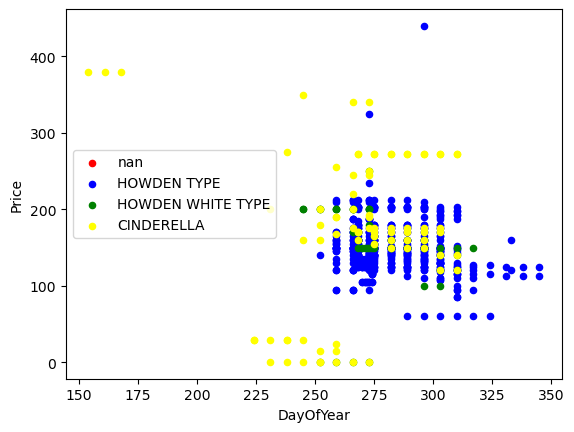

In [55]:
#Creating a scatter plot of price against DayOfYear grouping by variety
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    df = new_pumpkins[new_pumpkins['Variety']==var]
    ax = df.plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

Text(0.5, 0, 'Variety')

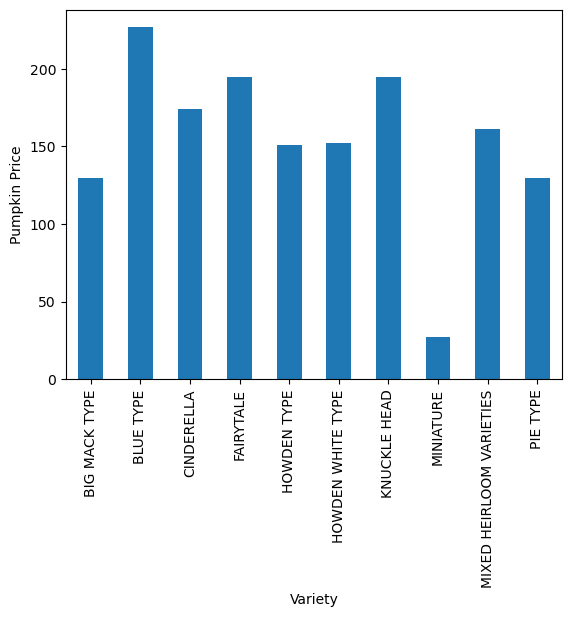

In [58]:
#Creating a barchart showing the mean price for each variety
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')
plt.ylabel('Pumpkin Price')
plt.xlabel('Variety')

<Axes: xlabel='DayOfYear', ylabel='Price'>

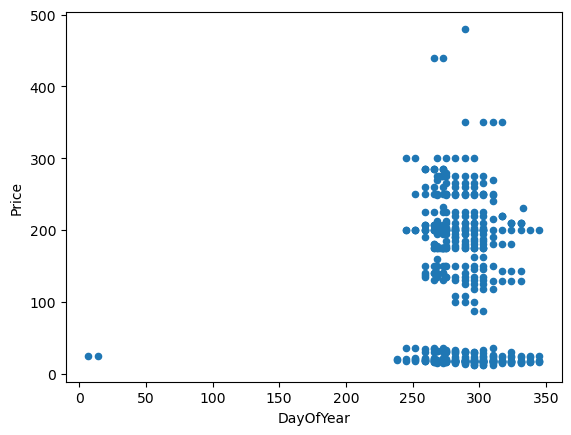

In [59]:
#Investigating the relationship between price and day of year for a particular variety
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
pie_pumpkins.plot.scatter('DayOfYear','Price')

In [60]:
#Dropping null observations
pie_pumpkins.dropna(inplace=True)
pie_pumpkins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 468 entries, 70 to 1708
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       468 non-null    int64  
 1   Package     468 non-null    object 
 2   Low Price   468 non-null    float64
 3   High Price  468 non-null    float64
 4   Price       468 non-null    float64
 5   Variety     468 non-null    object 
 6   DayOfYear   468 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 29.2+ KB


C:\Users\ryant\AppData\Local\Temp\ipykernel_14392\2534229087.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pie_pumpkins.dropna(inplace=True)


In [61]:
#Creating target and regressors
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

In [62]:
#Performing the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [63]:
#Generating and fitting the model to the data
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [64]:
#Testing the model and looking at the mean-square error which is a measure of fit
pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(mse)

101.80022768424395


In [65]:
#Looking at the score measure which is another measure of fit, we conclude that the fit of this model is very poor
#and does not account for much variation within the target variable which is price
score = lin_reg.score(X_train,y_train)
print('Model determination: ', score)

Model determination:  0.003436482600889801


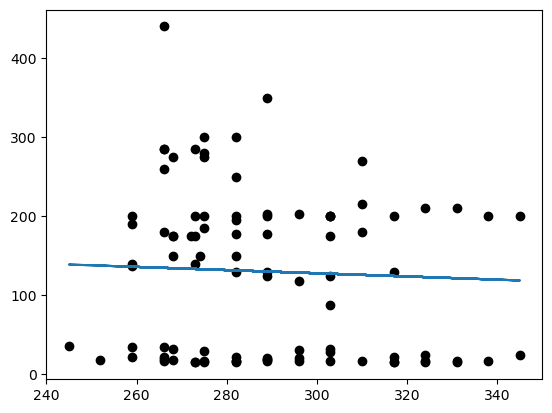

In [68]:
#Exploring the relationship between the independent and dependent variables
plt.scatter(X_test,y_test, color='k')
plt.plot(X_test,pred)

In [69]:
#Importing for polynomial model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [70]:
#Testing the polynomial model
pred_poly = pipeline.predict(X_test)

mse_poly = np.sqrt(mean_squared_error(y_test,pred_poly))
print(mse_poly)

101.18299501134935


In [71]:
score_poly = pipeline.score(X_train,y_train)
print('Model determination: ', score_poly)

Model determination:  0.034532645086604474


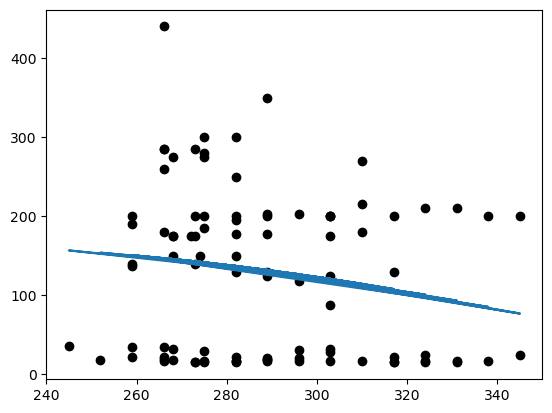

In [72]:
plt.scatter(X_test,y_test, color='k')
plt.plot(X_test,pred_poly)

In [73]:
#Creating dummy variables so that we can include variety in the model
#The model will be over-parameterised in this case
pd.get_dummies(new_pumpkins['Variety'])

,BIG MACK TYPE,BLUE TYPE,CINDERELLA,FAIRYTALE,HOWDEN TYPE,HOWDEN WHITE TYPE,KNUCKLE HEAD,MINIATURE,MIXED HEIRLOOM VARIETIES,PIE TYPE
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1752,0,0,0,0,0,0,0,1,0,0
1753,0,0,0,0,0,0,0,1,0,0
1754,0,0,0,0,0,0,0,1,0,0
1755,0,0,0,0,0,0,0,1,0,0


In [75]:
#Creating new dependent and independent variables 
X1 = pd.get_dummies(new_pumpkins['Variety'])
y1 = new_pumpkins['Price']

In [87]:
X1 = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))

In [88]:
#Performing train-test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=0)

#Creating pipeline
pipeline1 = make_pipeline(PolynomialFeatures(2), LinearRegression())
pipeline1.fit(X1_train,y1_train)

#Testing the model
pred1 = pipeline1.predict(X1_test)

In [90]:
#Calculating mean-square error and determination
mse1 = np.sqrt(mean_squared_error(y1_test,pred1))
print(mse1)

#As we can see, the determination is much closer to 1, thus, the model is a stronger fit
score1 = pipeline1.score(X1_train,y1_train)
print('Model determination: ', score1)

3716161797.7221694
Model determination:  0.9309187647325811
